In [1]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [2]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)


/local/storage/jz855/STARR_seq_code/Final_Code_Sharing


# Load data

In [3]:
# -----------------------------------------
# Load and process GRO-cap elements (K562)
# -----------------------------------------

# Define the input BED file path for GRO-cap elements
grocap_path = os.path.join(
    project_root,
    'data', 'reference', 'K562_GRO_cap', 'GRO_cap_element', 'processed_files',
    'GROcap_elements_all.bed'
)

# Load the BED file as a DataFrame (no header, tab-separated)
grocap_df = pd.read_csv(grocap_path, sep='\t', header=None)

# Create a unique identifier for each element based on chromosome, start, end
grocap_df['element_id'] = grocap_df[0].astype(str) + '_' + grocap_df[1].astype(str) + '_' + grocap_df[2].astype(str)

# Set the unique identifier as the index
grocap_df = grocap_df.set_index('element_id')

# Preview the processed DataFrame
grocap_df.head()



,0,1,2,3,4
element_id,,,,,
chr1_605357_605632,chr1,605357,605632,divergent,275
chr1_633969_634143,chr1,633969,634143,divergent,174
chr1_778552_778868,chr1,778552,778868,divergent,316
chr1_827157_827361,chr1,827157,827361,divergent,204
chr1_827435_827780,chr1,827435,827780,divergent,345


In [4]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [5]:
# Load dataset, orientation-independent calls

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'LentiMPRA', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
lentimpra = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(lentimpra))
lentimpra.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'ATAC_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
atac_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(atac_starr))
atac_starr.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'WHG_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
whg_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(whg_starr))
whg_starr.columns = columns



109468
304921
1622613


In [6]:
# -------------------------------------------------------------
# Annotate each assay dataset with corresponding GRO-cap element ID
# -------------------------------------------------------------
# For each dataset, create a unique GRO-cap element ID from overlapping coordinates
# If a region does not overlap any GRO-cap element (overlap_bp == 0), assign '.' as a placeholder

# -------------------------
# WHG-STARR-seq annotation
# -------------------------
whg_starr['GROcap_element_ID'] = (
    whg_starr['gro_chr'].astype(str) + '_' +
    whg_starr['gro_start'].astype(str) + '_' +
    whg_starr['gro_end'].astype(str)
)
# Mark non-overlapping regions with '.'
whg_starr.loc[whg_starr['gro_overlap_bp'] == 0, 'GROcap_element_ID'] = '.'

# -------------------------
# ATAC-STARR-seq annotation
# -------------------------
atac_starr['GROcap_element_ID'] = (
    atac_starr['gro_chr'].astype(str) + '_' +
    atac_starr['gro_start'].astype(str) + '_' +
    atac_starr['gro_end'].astype(str)
)
atac_starr.loc[atac_starr['gro_overlap_bp'] == 0, 'GROcap_element_ID'] = '.'

# -------------------------
# lentiMPRA annotation
# -------------------------
lentimpra['GROcap_element_ID'] = (
    lentimpra['gro_chr'].astype(str) + '_' +
    lentimpra['gro_start'].astype(str) + '_' +
    lentimpra['gro_end'].astype(str)
)
lentimpra.loc[lentimpra['gro_overlap_bp'] == 0, 'GROcap_element_ID'] = '.'



# Process data to obtain tested GRO-cap elements in different overlap categories in each dataset

In [7]:
def remove_duplicate_GROcap_element(df, gro_cap_col='GROcap_element_ID', region_name_col='name', overlap_col='gro_overlap_bp'):
    """
    Removes duplicate GRO-cap elements from a dataset while keeping:
    - All entries without overlap with GRO-cap elements (e.g., ccre_name == '.')
    - One representative entry per GRO-cap element (highest overlap_bp)

    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe with GRO-cap annotations.
    gro_cap_col : str
        Column name indicating the GRO-cap ID (default: 'GROcap_element_ID').
    region_name_col : str
        Column name indicating the unique region name (default: 'name').
    overlap_col : str
        Column name indicating the overlap score to prioritize (default: 'gro_overlap_bp').

    Returns:
    -------
    pd.DataFrame
        DataFrame with duplicates removed based on GRO-cap element ID.
    """
    print(f"Original entries: {len(df)}")

    # Keep rows without a cCRE assigned
    no_gro_cap = df[df[gro_cap_col] == '.']
    print(f"Entries without overlap with GRO-cap elements: {len(no_gro_cap)}")

    # Keep one representative row per cCRE, based on highest overlap
    tested_gro_cap = df[df[gro_cap_col] != '.']
    print(f"Entries overap with GRO-cap elements: {len(tested_gro_cap)}")

    tested_gro_cap = tested_gro_cap.sort_values(overlap_col, ascending=False)
    tested_gro_cap = tested_gro_cap.drop_duplicates(gro_cap_col)
    print(f"Unique GRO-cap elements: {len(tested_gro_cap)}")
    print(f"Unique tested region names: {len(tested_gro_cap.drop_duplicates(region_name_col))}")

    # Combine no cCRE and deduplicated tested cCRE entries
    cleaned_df = pd.concat([no_gro_cap, tested_gro_cap], ignore_index=True)
    print(f"Final entries after removing GRO-cap elements duplicates: {len(cleaned_df)}")

    print('--------')

    return cleaned_df



In [8]:
# ------------------------------------------
# Remove duplicate tested GRO-cap elements for each assay and report original and cleaned entry counts
# ------------------------------------------

# WHG-STARR-seq
whg_starr_clean = remove_duplicate_GROcap_element(whg_starr)

# ATAC-STARR-seq
atac_starr_clean = remove_duplicate_GROcap_element(atac_starr)

# LentiMPRA
lenti_clean = remove_duplicate_GROcap_element(lentimpra)




Original entries: 1622613
Entries without overlap with GRO-cap elements: 1573567
Entries overap with GRO-cap elements: 49046
Unique GRO-cap elements: 40632
Unique tested region names: 40632
Final entries after removing GRO-cap elements duplicates: 1614199
--------
Original entries: 304921
Entries without overlap with GRO-cap elements: 264025
Entries overap with GRO-cap elements: 40896
Unique GRO-cap elements: 34645
Unique tested region names: 34645
Final entries after removing GRO-cap elements duplicates: 298670
--------
Original entries: 109468
Entries without overlap with GRO-cap elements: 83146
Entries overap with GRO-cap elements: 26322
Unique GRO-cap elements: 25537
Unique tested region names: 25537
Final entries after removing GRO-cap elements duplicates: 108683
--------


In [9]:
# Loop through each dataset and assign GRO-cap overlap category to the GRO-cap elements DataFrame
for data, dataset in zip([whg_starr_clean, atac_starr_clean, lenti_clean], ['WHG_STARR', 'ATAC_STARR', 'LentiMPRA']):

    # Initialize with no overlap
    grocap_df[dataset] = '.'

    # Assign 'Low' if there is at least 1 bp overlap
    low_overlap = data[data['gro_overlap_bp'] > 0]['GROcap_element_ID'].tolist()
    grocap_df.loc[low_overlap, dataset] = 'Low'

    # Assign 'Moderate' if both region and cCRE have ≥50% reciprocal overlap
    moderate_overlap = data[
        (data['gro_overlap_pct_region'] >= 50) &
        (data['gro_overlap_pct_GROcap_element'] >= 50)
    ]['GROcap_element_ID'].tolist()
    grocap_df.loc[moderate_overlap, dataset] = 'Moderate'

    # Assign 'High' if both region and cCRE have ≥80% reciprocal overlap
    high_overlap = data[
        (data['gro_overlap_pct_region'] >= 80) &
        (data['gro_overlap_pct_GROcap_element'] >= 80)
    ]['GROcap_element_ID'].tolist()
    grocap_df.loc[high_overlap, dataset] = 'High'

    # Summary of assigned categories
    print(f"{dataset} - Overlap category distribution:")
    print(grocap_df[dataset].value_counts())
    print('-----')


WHG_STARR - Overlap category distribution:
WHG_STARR
Low         31984
.           21655
Moderate     7179
High         1469
Name: count, dtype: int64
-----
ATAC_STARR - Overlap category distribution:
ATAC_STARR
Low         27655
.           27642
Moderate     6022
High          968
Name: count, dtype: int64
-----
LentiMPRA - Overlap category distribution:
LentiMPRA
.           36750
Moderate    12696
Low          8024
High         4817
Name: count, dtype: int64
-----


In [10]:
grocap_df = grocap_df.reset_index()[[0,1,2,'element_id',3, 4, 'WHG_STARR', 'ATAC_STARR', 'LentiMPRA']]

grocap_df.head()


,0,1,2,element_id,3,4,WHG_STARR,ATAC_STARR,LentiMPRA
0,chr1,605357,605632,chr1_605357_605632,divergent,275,.,Low,.
1,chr1,633969,634143,chr1_633969_634143,divergent,174,.,.,Moderate
2,chr1,778552,778868,chr1_778552_778868,divergent,316,Moderate,Moderate,Moderate
3,chr1,827157,827361,chr1_827157_827361,divergent,204,Low,.,.
4,chr1,827435,827780,chr1_827435_827780,divergent,345,Moderate,Low,.


In [11]:
# ------------------------------------------
# Compute GRO-cap overlap statistics by GRO-cap element type and dataset
# ------------------------------------------

# Define GRO-cap elements categories to analyze
gro_cap_element_type = ['divergent', 'unidirectional', 'bidirectional']

# Initialize a list to hold summary DataFrames
stacked_df_list = []

# Iterate through each cCRE type
for gro in gro_cap_element_type:
    
    # Subset the master GRO-cap DataFrame for the current GRO-cap type
    df = grocap_df[grocap_df[3] == gro]
    
    # Loop through each functional genomics dataset
    for dataset in ['WHG_STARR', 'ATAC_STARR', 'LentiMPRA']:
        
        # Subset data by overlap level
        no_overlap      = df[df[dataset] == '.']
        low_overlap     = df[df[dataset] == 'Low']
        moderate_overlap = df[df[dataset] == 'Moderate']
        high_overlap    = df[df[dataset] == 'High']
        have_overlap    = df[df[dataset] != '.']
        
        # Build a DataFrame summarizing counts and percentages
        tmp = pd.DataFrame({
            'GROcap_type': [f"{gro}\n({len(df):,})"] * 5,
            'dataset': [dataset] * 5,
            'overlap_type': ['No_overlap', 'Low', 'Moderate', 'High', 'Have_overlap'],
            'count': [
                len(no_overlap), 
                len(low_overlap), 
                len(moderate_overlap), 
                len(high_overlap), 
                len(have_overlap)
            ],
            'total': [len(df)] * 5
        })

        # Compute percentage of each overlap category
        tmp['pct'] = tmp['count'] / tmp['total'] * 100

        # Append to list
        stacked_df_list.append(tmp)

# Concatenate all cCRE-overlap summaries into one DataFrame
stacked_df = pd.concat(stacked_df_list, axis=0, ignore_index=True)

# Output dimensions of the result
print(f"Number of overlap summary entries: {len(stacked_df)}")



Number of overlap summary entries: 45


In [12]:
stacked_df

,GROcap_type,dataset,overlap_type,count,total,pct
0,"divergent\n(51,261)",WHG_STARR,No_overlap,17188,51261,33.530364
1,"divergent\n(51,261)",WHG_STARR,Low,26535,51261,51.764499
2,"divergent\n(51,261)",WHG_STARR,Moderate,6217,51261,12.128129
3,"divergent\n(51,261)",WHG_STARR,High,1321,51261,2.577008
4,"divergent\n(51,261)",WHG_STARR,Have_overlap,34073,51261,66.469636
5,"divergent\n(51,261)",ATAC_STARR,No_overlap,21173,51261,41.304305
6,"divergent\n(51,261)",ATAC_STARR,Low,24220,51261,47.248395
7,"divergent\n(51,261)",ATAC_STARR,Moderate,4998,51261,9.750102
8,"divergent\n(51,261)",ATAC_STARR,High,870,51261,1.697197
9,"divergent\n(51,261)",ATAC_STARR,Have_overlap,30088,51261,58.695695


# Plot tested coverage of GRO-cap elements

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns

def stacked_bar_distribution(data, gro_cap_list, element_order_list, 
                             colormap, label_map, ytick_label_list, 
                             title, out_path=''):
    """
    Plots a horizontal stacked bar chart showing the distribution of overlap types
    across different GRO-cap element categories.

    Parameters:
    - data (pd.DataFrame): MPRA/STARR-seq DataFrame
    - gro_cap_list (list of str): Ordered list of GRO-cap types to plot.
    - element_order_list (list of str): Order of overlap categories to stack (e.g., ['No_overlap', 'Low', 'Moderate', 'High']).
    - colormap (dict): Mapping from overlap types to colors.
    - label_map (dict): Mapping from overlap types to legend labels.
    - ytick_label_list (list of str): Labels to display on the y-axis (e.g., with counts).
    - title (str): Title of the plot.
    - out_path (str): File path to save the figure. If empty, the plot is not saved.
    """

    # Set up plot
    fig, ax = plt.subplots(figsize=(10, 1.2 * len(gro_cap_list)))
    ax.grid(False)

    # Create y-axis index from top to bottom
    index = list(range(1, len(gro_cap_list) + 1))
    index.sort(reverse=True)

    bar_width = 0.8
    opacity = 0.8

    # Initialize "left" to zero for the first stack
    left = np.zeros(len(gro_cap_list))

    # Plot each overlap type as a horizontal bar
    for i, element in enumerate(element_order_list):
        df = data[data['overlap_type'] == element]

        # Extract values to plot
        curr = df['pct'].values

        # Plot the bar
        ax.barh(index, curr, bar_width,
                color=colormap[element],
                align='center',
                alpha=opacity,
                left=left)

        # Update left position for next stack
        left += curr

    # Axis labels and limits
    ax.set_xlabel('Percentage', fontsize=18)
    ax.set_xlim([0, 100])
    ax.set_ylabel('')
    ax.set_ylim([0.5, len(gro_cap_list) + 0.5])

    # Y-axis ticks and labels
    ax.set_yticks(index)
    ax.set_yticklabels(ytick_label_list, fontsize=17)

    # Format x-axis tick labels with percentage signs
    xticks = ax.get_xticks()
    ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)

    # Remove top/right spines
    sns.despine()

    # Add legend
    legend_handles = [mpatches.Patch(color=colormap[e], label=label_map[e]) for e in element_order_list]
    ax.legend(handles=legend_handles,
              bbox_to_anchor=(0.5, -0.2),
              loc='upper center',
              ncol=2,
              fancybox=True,
              fontsize=17)

    # Set plot title
    ax.set_title(title, fontsize=20)

    # Save figure if path provided
    if out_path:
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)

    

In [28]:
# ------------------------------------------
# Set plot parameters for stacked bar visualization
# ------------------------------------------

# Define the order of overlap categories for plotting
element_order_list = ['High', 'Moderate', 'Low', 'No_overlap']

# Define color palette for each overlap category
palette = {
    'No_overlap': '#f0f9e8',
    'Low': '#EBD3A9',
    'Moderate': '#EDB699',
    'High': '#FF8685'
}

# Define label mapping for legend entries
label_map = {
    'No_overlap': 'Not Tested',
    'Low': 'Rest of Overlap',
    'Moderate': '50% - 80% Reciprocal Overlap',
    'High': u'$\geq$ 80% Reciprocal Overlap'
}

# ------------------------------------------
# Extract unique y-axis labels (formatted cCRE names)
# ------------------------------------------

ytick_label_list = []
seen = set()

# Collect the first appearance of each cCRE name (with count annotation)
for idx in stacked_df.index:
    gro_cap_label = stacked_df.loc[idx, 'GROcap_type']
    if gro_cap_label not in seen:
        ytick_label_list.append(gro_cap_label)
        seen.add(gro_cap_label)


# Capitalize the first character of each y-axis label
original_ytick_label_list = [label.capitalize() for label in ytick_label_list]

ytick_label_list = [label.replace('Bidirectional', 'Convergent') for label in original_ytick_label_list]

# Display all extracted y-axis labels
print("Full ytick_label_list:")
print(ytick_label_list)
print(original_ytick_label_list)




Full ytick_label_list:
['Divergent\n(51,261)', 'Unidirectional\n(6,981)', 'Convergent\n(4,045)']
['Divergent\n(51,261)', 'Unidirectional\n(6,981)', 'Bidirectional\n(4,045)']


## WHG-STARR-seq

<ipython-input-27-7cead1dffbb0>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


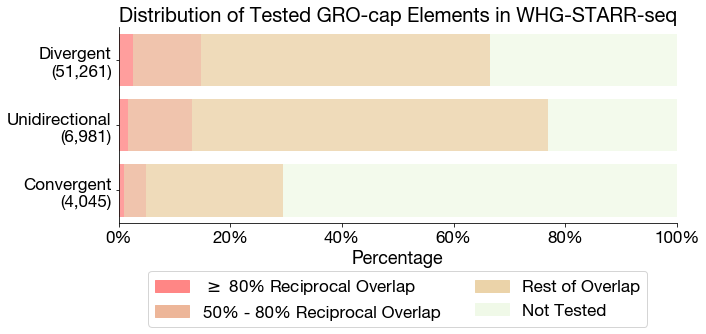

In [34]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in WHG-STARR-seq
# ------------------------------------------

# Filter the dataset to only include WHG-STARR-seq data
whg_starr_plot_df = stacked_df[stacked_df['dataset'] == 'WHG_STARR']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=whg_starr_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested GRO-cap Elements in WHG-STARR-seq'
)

## ATAC-STARR-seq

<ipython-input-27-7cead1dffbb0>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


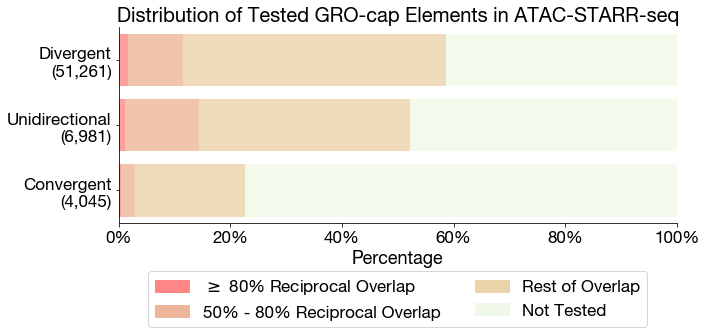

In [33]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in ATAC-STARR-seq
# ------------------------------------------

# Filter the dataset to only include ATAC-STARR-seq data
atac_starr_plot_df = stacked_df[stacked_df['dataset'] == 'ATAC_STARR']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=atac_starr_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested GRO-cap Elements in ATAC-STARR-seq'
)


## LentiMPRA

<ipython-input-27-7cead1dffbb0>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


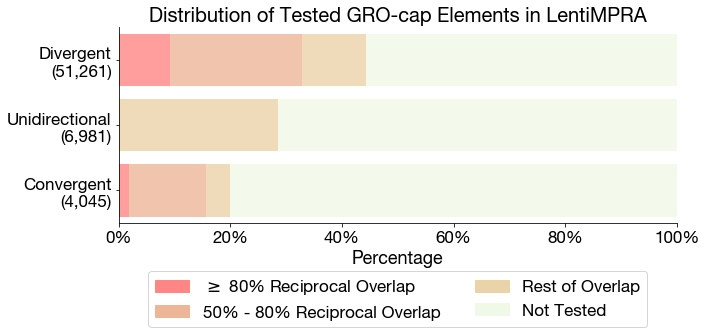

In [32]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in LentiMPRA
# ------------------------------------------

# Filter the dataset to only include ATAC-STARR-seq data
lenti_plot_df = stacked_df[stacked_df['dataset'] == 'LentiMPRA']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=lenti_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested GRO-cap Elements in LentiMPRA'
)


In [40]:
atac_starr_plot_df.head()

,GROcap_type,dataset,overlap_type,count,total,pct
5,"divergent\n(51,261)",ATAC_STARR,No_overlap,21173,51261,41.304305
6,"divergent\n(51,261)",ATAC_STARR,Low,24220,51261,47.248395
7,"divergent\n(51,261)",ATAC_STARR,Moderate,4998,51261,9.750102
8,"divergent\n(51,261)",ATAC_STARR,High,870,51261,1.697197
9,"divergent\n(51,261)",ATAC_STARR,Have_overlap,30088,51261,58.695695


## Plot tested coverage statistics for the three datasets together

In [41]:
def stacked_bar_subplot(ax, data, gro_cap_list, element_order_list, 
                        colormap, label_map, ytick_label_list, 
                        ylabel, hide_xaxis=False, legend=False):
    """
    Plots a horizontal stacked bar chart on a provided matplotlib Axes object.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes object to plot the stacked bar chart on.
    - data (pd.DataFrame): Input Dataframe
    - label_map (list of str): List of GRO-cap element types to plot.
    - element_order_list (list of str): Order in which overlap types should be stacked.
    - colormap (dict): Mapping from overlap_type to color.
    - label_map (dict): Mapping from overlap_type to legend label.
    - ytick_label_list (list of str): Labels for the y-axis (one per GRO-cap element type).
    - ylabel (str): Label for the y-axis.
    - hide_xaxis (bool): Whether to hide the x-axis labels and ticks.
    - legend (bool): Whether to include a legend.
    """
    
    # Disable grid for cleaner visualization
    ax.grid(False)
    
    # Create reversed y-axis positions for top-down bar stacking
    index = list(range(1, len(gro_cap_list)+1))[::-1]
    bar_width = 0.8
    opacity = 0.8

    # Stack each overlap_type as horizontal bar segments
    for i, element in enumerate(element_order_list):
        df = data[data['overlap_type'] == element]
        if i == 0:
            # Initialize left edge for each bar
            left = np.zeros(len(set(df['GROcap_type'].tolist())))
        curr = df['pct'].values  # Segment width (percentage)
        ax.barh(index, curr, bar_width, color=colormap[element], 
                align='center', alpha=opacity, left=left)
        left += curr  # Update left edge for the next segment

    # Set axis labels and ticks
    ax.set_ylabel(ylabel, fontsize=17)
    ax.set_xlim([0, 100])
    ax.set_yticks(index)
    ax.set_yticklabels(ytick_label_list, rotation=0, fontsize=15)
    ax.set_ylim([0.5, len(gro_cap_list) + 0.5])

    # Configure x-axis appearance based on input flag
    if hide_xaxis:
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
        ax.minorticks_off()
        ax.set_xlabel('', fontsize=20)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
    else:
        # Format x-axis ticks as percentages
        xticks = ax.get_xticks()
        ax.set_xticklabels([f"{int(round(x))}%" for x in xticks], fontsize=15)
        ax.set_xlabel('Percentage', fontsize=17)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    # Create and show legend if specified
    if legend:
        legend_handles = [
            mpatches.Patch(color=colormap[e], label=label_map[e])
            for e in element_order_list
        ]
        plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, -0.3), loc='upper center', 
                   fancybox=True, ncol=2, fontsize=17)
        
        

LentiMPRA entries: 15
ATAC-STARR-seq entries: 15
WHG-STARR-seq entries: 15


<ipython-input-41-e4a74a6e055a>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{int(round(x))}%" for x in xticks], fontsize=15)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


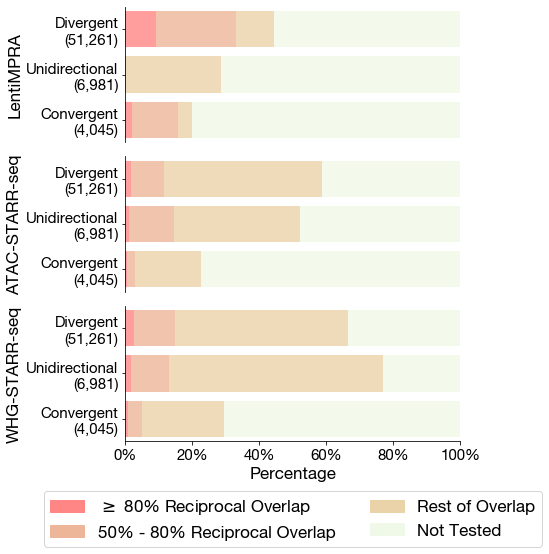

In [43]:
# Set up figure and layout
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(hspace=0.1)  # Adjust vertical space between subplots
row = 0  # Start row index

# ----------------------------
# LentiMPRA
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1)
print(f"LentiMPRA entries: {len(lenti_plot_df)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=lenti_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    ylabel='LentiMPRA',
    hide_xaxis=True,
    legend=False
)
row += 1

# ----------------------------
# ATAC-STARR-seq
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1, sharex=ax)
print(f"ATAC-STARR-seq entries: {len(atac_starr_plot_df)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=atac_starr_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    ylabel='ATAC-STARR-seq',
    hide_xaxis=True,
    legend=False
)
row += 1

# ----------------------------
# WHG-STARR-seq
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1, sharex=ax)
print(f"WHG-STARR-seq entries: {len(whg_starr_plot_df)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=whg_starr_plot_df,
    gro_cap_list=gro_cap_element_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    ylabel='WHG-STARR-seq',
    hide_xaxis=False,
    legend=True  # Only show legend for last plot
)

# Save the figure
out_path = os.path.join(project_root, 'plot', 'active_rate', 'GROcap_elements_tested_coverage_three_assays.pdf')
if(out_path != ''):
    plt.savefig(
        out_path,
        bbox_inches='tight',
        transparent=True,
        dpi=300
    )
    

# Assess active rate of each type of GRO-cap elements in different overlap category

In [44]:
def compute_active_rate_summary(df):
    """
    Compute active/inactive region counts and active rate from a DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        Subset DataFrame of tested regions with a 'call' column.

    Returns:
    -------
    Tuple[int, int, int, float]
        - num_active: Number of active regions
        - num_inactive: Number of inactive regions
        - num_total: Total number of regions
        - active_rate: Percentage of active regions among total (0–100)
    """
    num_total = len(df)

    if num_total > 0:
        num_active = len(df[df['call'] == 'active'])
        num_inactive = len(df[df['call'] == 'inactive'])
        active_rate = num_active / num_total * 100
    else:
        num_active = 0
        num_inactive = 0
        active_rate = 0.0

    return num_active, num_inactive, num_total, active_rate


def calculate_active_region_stats(data, category_col, category_value):
    """
    Calculate activity statistics (active, inactive, and total counts) for a specific category.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing a 'call' column indicating whether a region is 'active' or 'inactive',
        along with a categorical column to group by (e.g., 'promoter_1kb_tss', 'divergent', etc.).

    category_col : str
        The name of the column containing category labels to subset the data.

    category_value : str
        The specific category value within `category_col` to calculate statistics for.

    Returns:
    --------
    tuple : (int, int, int, float)
        - Number of active regions
        - Number of inactive regions
        - Total number of regions
        - Percentage of active regions (0–100%)
    """

    subset = data[data[category_col] == category_value]
    return compute_active_rate_summary(subset)


def format_annotation_text(row):
    """
    Format text annotation for active rate display.

    Given a row from a DataFrame that includes the number of active and total regions,
    this function returns a string in the format:
        "X,XXX/Y,YYY (Z%)"
    where:
        - X,XXX is the number of active regions (with comma formatting)
        - Y,YYY is the total number of regions (with comma formatting)
        - Z% is the active rate percentage, rounded to:
            - 1 decimal place if < 1%
            - nearest integer if ≥ 1%

    Parameters:
    -----------
    row : pd.Series
        A row from a DataFrame containing 'num_active', 'num_total', and 'active_rate' columns.

    Returns:
    --------
    str
        Formatted string annotation.
    """
    # Extract values from the row
    active = row['num_active']
    total = row['num_total']
    rate = row['active_rate']

    # Format percentage: 1 decimal if <1%, otherwise round to whole number
    if rate < 1:
        percent_str = f"{rate:.1f}%"
    else:
        percent_str = f"{round(rate):.0f}%"

    # Format string: "X,XXX/Y,YYY (Z%)"
    return f"{active:,}/{total:,} ({percent_str})"


In [46]:
print(whg_starr_clean['divergent'].value_counts())
whg_starr_clean.head()


divergent
.           1580126
low           26535
moderate       6217
high           1321
Name: count, dtype: int64


,chr,start,end,name,logFC,strand,z_score,size,call,forward_raw,reverse_raw,total_raw,forward_signal,reverse_signal,total_signal,gro_chr,gro_start,gro_end,gro_type,gro_size,gro_overlap_bp,gro_overlap_pct_region,gro_overlap_pct_GROcap_element,ccre_chr,ccre_start,ccre_end,ccre_name,ccre_type,ccre_size,ccre_overlap_bp,ccre_overlap_pct_region,ccre_overlap_pct_ccre,promoter_400bp_tss,promoter_1kb_tss,promoter_4kb_tss,separate_GROcap_signal_levels,binary_transcription_class,divergent,unidirectional,bidirectional,not_overlap_GROcap_elements,CA_CTCF,CA_H3K4me3,CA_TF,dELS,pELS,Low_DNase,PLS,CA_only,not_overlap_cCRE,ELS,ELS_PLS,GROcap_element_ID
0,chr6,96260920,96262230,inactive_region_1234004,.,.,.,1310,inactive,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.0,-0.0,chr6,96260938,96261288,EH38E3722012,Low-DNase,350,350,26.717557,100.0,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.,.
1,chr17,39243860,39245280,inactive_region_558713,.,.,.,1420,inactive,2.0,10.0,12.0,0.001408,0.007042,0.008451,.,-1,-1,.,-1,0,0.0,-0.0,chr17,39243973,39244323,EH38E3221461,Low-DNase,350,350,24.647887,100.0,N,N,N,low_transcription,transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.,.
2,chr8,128935350,128936120,inactive_region_1440066,.,.,.,770,inactive,1.0,-0.0,1.0,0.001299,-0.000000,0.001299,.,-1,-1,.,-1,0,0.0,-0.0,chr8,128935731,128936081,EH38E2667273,Low-DNase,350,350,45.454545,100.0,N,N,N,low_transcription,transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.,.
3,chr2,240453650,240465950,inactive_region_792545,.,.,.,12300,inactive,0.0,19.0,19.0,0.000000,0.001545,0.001545,.,-1,-1,.,-1,0,0.0,-0.0,chr2,240457641,240457991,EH38E3413035,Low-DNase,350,350,2.845528,100.0,N,N,N,low_transcription,transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.,.
4,chr18,6370970,6372330,inactive_region_586830,.,.,.,1360,inactive,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.0,-0.0,chr18,6371386,6371736,EH38E4175547,Low-DNase,350,350,25.735294,100.0,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.,.


In [47]:
# --------------------------------------------------------------
# Analyze Active Rates Across GRO-cap Element Types and Overlap Categories
# --------------------------------------------------------------

# Define GRO-cap categories and overlap classifications
gro_cap_type_col_list = [
    'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements'
]
overlap_class_list = ['low', 'moderate', 'high']

# Container to hold active region stats across all datasets
all_stats_by_dataset = []

# Loop over each dataset and label
for dataset_df, dataset_name in zip(
    [whg_starr_clean, atac_starr_clean, lenti_clean], 
    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']
):
    dataset_stats_rows = []

    for grocap_col in gro_cap_type_col_list:
        
        if grocap_col == 'not_overlap_GROcap_elements':
            # Handle regions that do not overlap with any GRO-cap elements
            num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
                dataset_df, grocap_col, 'not_overlap_GROcap_elements'
            )
            dataset_stats_rows.append((
                dataset_name, grocap_col, 'not_overlap_GROcap_elements',
                num_active, num_inactive, num_total, active_rate
            ))
            continue
        
        # Loop through overlap classifications for GRO-cap element
        for overlap_class in overlap_class_list:
            num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
                dataset_df, grocap_col, overlap_class
            )
            dataset_stats_rows.append((
                dataset_name, grocap_col, overlap_class,
                num_active, num_inactive, num_total, active_rate
            ))

    # Create a DataFrame of the stats for the current dataset
    dataset_stats_df = pd.DataFrame(
        dataset_stats_rows,
        columns=[
            'dataset', 'category_col', 'category_value',
            'num_active', 'num_inactive', 'num_total', 'active_rate'
        ]
    )
    
    all_stats_by_dataset.append(dataset_stats_df)

# Concatenate results across all datasets into one DataFrame
combined_stats_df = pd.concat(all_stats_by_dataset, axis=0, ignore_index=True)

# --------------------------------------------------------------
# Format annotation text as "active/total (X%)"
# Adds thousands separators and rounds percentages:
#   - one decimal if <1%, else no decimals
# --------------------------------------------------------------
combined_stats_df['text'] = combined_stats_df.apply(format_annotation_text, axis=1)

# Uncomment below to preview final results
# print(combined_stats_df.head())


In [49]:
# ---------------------------------------------------------
# Function: barplot_subplot_sharex
# Description:
#   Draws a grouped barplot using seaborn with optional axis sharing.
#   Also annotates each bar with custom text values (e.g., percentages).
#
# Parameters:
#   - ax: matplotlib Axes object for plotting
#   - data: DataFrame containing the plotting data
#   - x, y: column names for x-axis and y-axis values
#   - hue: column name for categorical grouping
#   - hue_order: list defining order of hue categories
#   - x_order: list defining order of x-axis categories
#   - palette: dict mapping hue values to color codes
#   - xlabel, ylabel: axis labels
#   - xticklabel: custom x-axis tick labels
#   - legend: whether to show legend
#   - hide_xaxis: whether to hide x-axis (for subplots)
# ---------------------------------------------------------

def barplot_subplot_sharex(ax, data, x, y, hue, hue_order, 
                           x_order, palette, xlabel, ylabel, 
                           xticklabel, legend=False, hide_xaxis=False):

    # Draw grouped barplot without error bars
    sns.barplot(
        data=data, x=x, y=y, hue=hue, ax=ax,
        hue_order=hue_order, order=x_order, 
        width=0.8, errorbar=None, palette=palette, legend=legend
    )
    
    # Format y-axis: percentage with '%' sign
    ax.set_ylim([0, 100])
    ytick_vals = ax.get_yticks().tolist()
    ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
    ax.set_ylabel(ylabel, fontsize=20)
    
    # Prepare annotation text for each bar from the "text" column
    labels = []
    for h_val in hue_order:
        for x_val in x_order:
            tmp = data[(data[x] == x_val) & (data[hue] == h_val)]
            label = tmp['text'].tolist()[0] if not tmp.empty else ''
            labels.append(label)

    # Add annotation text on top of each bar
    for bar, label in zip(ax.patches, labels):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 100, label,
            ha='center', va='top', rotation=90, fontsize=15
        )
    
    # Format x-axis
    if hide_xaxis:
        ax.xaxis.set_tick_params(left=False, labelleft=False)
        ax.minorticks_off()
        ax.set_xlabel('', fontsize=20)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
    else:
        ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
        ax.set_xlabel(xlabel, fontsize=17)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    # Optional legend
    if legend:
        handles = [
            mpatches.Patch(color=palette['high'], label='High'),
            mpatches.Patch(color=palette['moderate'], label='Moderate'),
            mpatches.Patch(color=palette['low'], label='Low')
        ]
        ax.legend(
            handles=handles,
            bbox_to_anchor=(0.95, -0.4),
            fancybox=True,
            borderaxespad=0.0,
            fontsize=17,
            ncol=3
        )


<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


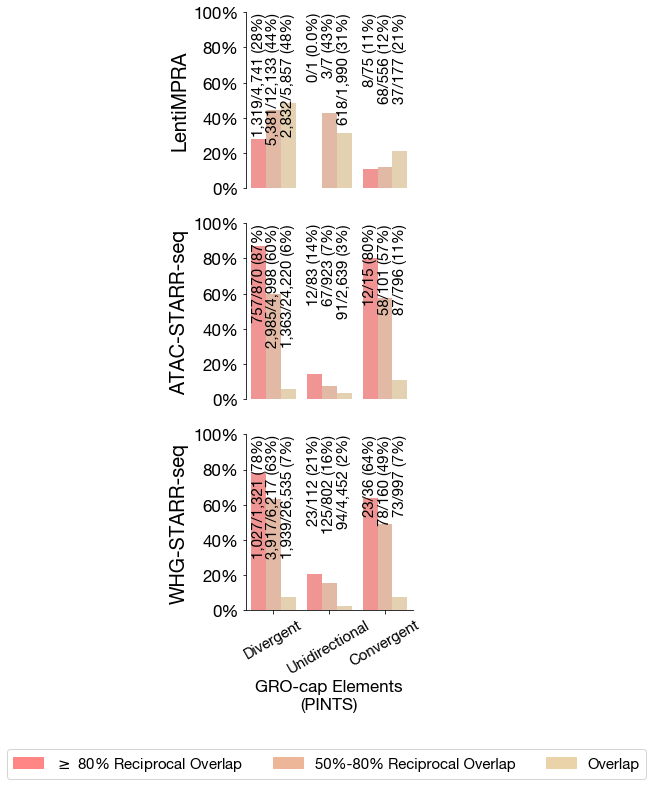

In [55]:
# -----------------------------------------------
# Plot Active Rates Across GRO-cap element Types in 3 Assays
# -----------------------------------------------

# Define key plotting parameters
x = 'category_col'  # X-axis: GRO-cap element category
y = 'active_rate'    # Y-axis: percentage of active elements
hue = 'category_value'     # Hue: overlap class
hue_order = ['high', 'moderate', 'low']  # Overlap categories
x_order = ['divergent', 'unidirectional', 'bidirectional']  # Internal variable names
xtick_labels = ['Divergent', 'Unidirectional', 'Convergent']  # Displayed x-axis labels

# Color mapping for different overlap classes
palette = {
    'high': '#FF8685',        # ≥80% reciprocal overlap
    'moderate': '#EDB699',    # 50–80% reciprocal overlap
    'low': '#EBD3A9',         # Other overlap
    'None': '#f0f9e8'         # Not used here but kept for consistency
}

category_type = 'GRO-cap Elements\n(PINTS)'

# Initialize figure
fig = plt.figure(figsize=(3, 11))
plt.subplots_adjust(hspace=0.2)

# -----------------------
# LentiMPRA Subplot
# -----------------------
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'LentiMPRA') & 
                              (combined_stats_df['category_col'] != 'not_overlap_GROcap_elements')]
barplot_subplot_sharex(
    ax=ax1, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='LentiMPRA',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# ATAC-STARR-seq Subplot
# -----------------------
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'ATAC-STARR-seq') & 
                              (combined_stats_df['category_col'] != 'not_overlap_GROcap_elements')]
barplot_subplot_sharex(
    ax=ax2, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='ATAC-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# WHG-STARR-seq Subplot
# -----------------------
ax3 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'WHG-STARR-seq') & 
                              (combined_stats_df['category_col'] != 'not_overlap_GROcap_elements')]
barplot_subplot_sharex(
    ax=ax3, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='WHG-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=False
)

# -----------------------
# Legend (Global for Figure)
# -----------------------
legend_handles = [
    mpatches.Patch(color=palette['high'], label=u'$\geq$ 80% Reciprocal Overlap'),
    mpatches.Patch(color=palette['moderate'], label='50%-80% Reciprocal Overlap'),
    mpatches.Patch(color=palette['low'], label='Overlap')
]
fig.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, -0.05), loc='upper center',
    fancybox=True, borderaxespad=0., fontsize=15, ncol=3
)

# -----------------------
# Save Plot
# -----------------------
out_path = os.path.join(project_root, 'plot', 'active_rate', 'active_rate_of_all_types_GRO_cap_elements.pdf')
if(out_path != ''):
    plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)



# Plot active rate for regions not overlap with GROcap elements (Transcribed vs. Untranscribed)

In [61]:
# --------------------------------------------------------------
# Analyze Active Rates of Tested Reginos Not Overlapping With GRO-cap Elements
# --------------------------------------------------------------

# Define col class
transcription_class_list = [
    'transcribed', 'not_transcribed'
]


# Container to hold active region stats across all datasets
all_stats_by_dataset = []

# Loop over each dataset and label
for dataset_df, dataset_name in zip(
    [whg_starr_clean, atac_starr_clean, lenti_clean], 
    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']
):
    dataset_stats_rows = []

    dataset_df = dataset_df[(dataset_df['not_overlap_GROcap_elements'] == 'not_overlap_GROcap_elements')]
        
    # Loop through transcription class
    for transcription_class in transcription_class_list:
        num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
            dataset_df, 'binary_transcription_class', transcription_class
        )
        dataset_stats_rows.append((
            dataset_name, 'binary_transcription_class', transcription_class,
            num_active, num_inactive, num_total, active_rate
        ))

    # Create a DataFrame of the stats for the current dataset
    dataset_stats_df = pd.DataFrame(
        dataset_stats_rows,
        columns=[
            'dataset', 'category_col', 'category_value',
            'num_active', 'num_inactive', 'num_total', 'active_rate'
        ]
    )
    
    all_stats_by_dataset.append(dataset_stats_df)

# Concatenate results across all datasets into one DataFrame
combined_stats_df = pd.concat(all_stats_by_dataset, axis=0, ignore_index=True)

# --------------------------------------------------------------
# Format annotation text as "active/total (X%)"
# Adds thousands separators and rounds percentages:
#   - one decimal if <1%, else no decimals
# --------------------------------------------------------------
combined_stats_df['text'] = combined_stats_df.apply(format_annotation_text, axis=1)

# Uncomment below to preview final results
print(combined_stats_df.head())


          dataset                category_col   category_value  num_active   
0   WHG-STARR-seq  binary_transcription_class      transcribed        6306  \
1   WHG-STARR-seq  binary_transcription_class  not_transcribed        8491   
2  ATAC-STARR-seq  binary_transcription_class      transcribed        3519   
3  ATAC-STARR-seq  binary_transcription_class  not_transcribed        1334   
4       LentiMPRA  binary_transcription_class      transcribed        4404   

   num_inactive  num_total  active_rate                    text  
0        294911     301217     2.093507      6,306/301,217 (2%)  
1       1263859    1272350     0.667348  8,491/1,272,350 (0.7%)  
2         88229      91748     3.835506       3,519/91,748 (4%)  
3        170943     172277     0.774334    1,334/172,277 (0.8%)  
4         35859      40263    10.938082      4,404/40,263 (11%)  


<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-49-4359e3547172>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


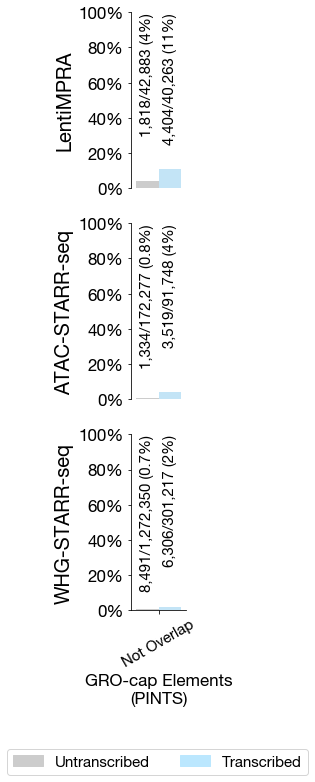

In [62]:
# -----------------------------------------------
# Plot Active Rates Two Transcription Classess in Three Assays For Regions Not Overlapping with Any GRO-cap Elements
# -----------------------------------------------

# Define key plotting parameters
x = 'category_col'  # X-axis: GRO-cap element category
y = 'active_rate'    # Y-axis: percentage of active elements
hue = 'category_value'     # Hue: overlap class
hue_order = ['not_transcribed', 'transcribed']  # Overlap categories
x_order = ['binary_transcription_class']  # Internal variable names
xtick_labels = ['Not Overlap']  # Displayed x-axis labels

# Color mapping for different overlap classes
palette = {
    'high': '#FF8685',        # ≥80% reciprocal overlap
    'moderate': '#EDB699',    # 50–80% reciprocal overlap
    'low': '#EBD3A9',         # Other overlap
    'None': '#f0f9e8',       # Not used here but kept for consistency
    'not_transcribed': '#cccccc', # Not transcribed
    'transcribed':'#BBE7FE'
}

category_type = 'GRO-cap Elements\n(PINTS)'

# Initialize figure
fig = plt.figure(figsize=(1, 11))
plt.subplots_adjust(hspace=0.2)

# -----------------------
# LentiMPRA Subplot
# -----------------------
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'LentiMPRA')]
barplot_subplot_sharex(
    ax=ax1, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='LentiMPRA',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# ATAC-STARR-seq Subplot
# -----------------------
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'ATAC-STARR-seq')]
barplot_subplot_sharex(
    ax=ax2, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='ATAC-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# WHG-STARR-seq Subplot
# -----------------------
ax3 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'WHG-STARR-seq')]
barplot_subplot_sharex(
    ax=ax3, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='WHG-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=False
)

# -----------------------
# Legend (Global for Figure)
# -----------------------
legend_handles = [
    mpatches.Patch(color=palette['not_transcribed'], label='Untranscribed'),
    mpatches.Patch(color=palette['transcribed'], label='Transcribed')
]
fig.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, -0.05), loc='upper center',
    fancybox=True, borderaxespad=0., fontsize=15, ncol=3
)

# ------------------------------------------
# Save figure to PDF
# ------------------------------------------
out_path = os.path.join(project_root, 'plot', 'active_rate', 'active_rate_of_regions_not_overlap_with_GRO_cap_elements.pdf')
if out_path:
    plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
    
